Below is the code used to generate the final models. Please note that it includes the random forest (final model), SVM and logistic regression models.
The code base heavily relies on the template provided for this asssigment. 
This code base was tuned manualy as I experimented with different paramters, however the code submitted was my optimal results. 

Please note that this is my experimental code base. There was a seperate file *(also submitted) which I used for my EDA. 

In [32]:
# mount the google drive in your notebook in case you want to use Google Colab
# if you want to use your local machine, you don't need to run this cell instead, you need to download the data and load it locally
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#to import cv2 on your local machine, first run pip install opencv-python
import cv2

In [34]:
base_url = '/content/drive/Shareddrives/FIT5149_TP6_A2/' # the shared drive base url
train_df = pd.read_csv(base_url + 'trainset_students.csv')
train_df.head()

,ID,Label,Label_Confidence
0,818021711,Positive,0.6715
1,911806503,Positive,0.6642
2,882035319,Negative,0.6683
3,880892525,Neutral,0.3360
4,828003448,Positive,1.0000


Here, after refering to EDA file, insert label confidence cut off criteria, i.e. reduce the dataframe size to sample above a certain level of label confidence.

In [35]:
#Reduced df size based off a Label_Confidence Criteria of >= 0.4
conf_level = train_df['Label_Confidence'] > 0.5
train_df_65_conf = train_df[conf_level]
train_df = train_df_65_conf
train_df

,ID,Label,Label_Confidence
0,818021711,Positive,0.6715
1,911806503,Positive,0.6642
2,882035319,Negative,0.6683
4,828003448,Positive,1.0000
5,146000529,Positive,0.6716
...,...,...,...
9431,480549023,Positive,1.0000
9432,316247246,Positive,0.6667
9433,455970656,Positive,0.6716
9434,380127764,Positive,0.6677


Feature Extraction - Provided by template

In [36]:
!pip install mahotas==1.4.11

In [37]:
#import libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
#to import mahotas on your local machine first run pip install mahotas==1.4.11
import mahotas
#to import cv2 on your local machine, first run pip install opencv-python
import cv2
import os

Feature Extractors

In [38]:
# feature-descriptor-1: Hu Moments
# here is more info about this feature
# https://learnopencv.com/shape-matching-using-hu-moments-c-python/
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

In [39]:
# feature-descriptor-2: Haralick Texture
# here is more info about this feature
# https://www.nature.com/articles/s41598-017-04151-4

def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick

In [40]:
# feature-descriptor-3: Color Histogram
# here is more info about this feature
# https://en.wikipedia.org/wiki/Color_histogram
def fd_histogram(image, mask=None, bins = 8):
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()

In [42]:
# to convert the input image to a fixed size of (500, 500).
# this can take a while on Colab beacuse of the I/O time (around 30 minutes, I stopped it after 20!)
fixed_size = tuple((500, 500))

# empty lists to hold feature vectors and labels
global_features = []
labels = []
confidence = []

# loop over the images
for row in train_df.iterrows():
    # get the image file name
    file = base_url + "images/"  + str(row[1]['ID']) + ".jpg"

    # read the image and resize it to a fixed-size
    image = cv2.imread(file)
    image = cv2.resize(image, fixed_size)

    ####################################
    # Global Feature extraction
    ####################################
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick   = fd_haralick(image)
    fv_histogram  = fd_histogram(image, bins = 8)

    ###################################
    # Concatenate global features
    ###################################
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
    # global_feature = np.hstack([fv_histogram, fv_hu_moments])

    # update the list of labels and feature vectors
    labels.append(row[1]['Label'])
    confidence.append(row[1]['Label_Confidence'])
    global_features.append(global_feature)

In [66]:
# get the overall feature vector size
print("[STATUS] feature vector size {}".format(np.array(global_features).shape))

# get the overall training label size
print("[STATUS] training Labels {}".format(np.array(labels).shape))

# encode the target labels
targetNames = np.unique(labels)
le = LabelEncoder()
target = le.fit_transform(labels)
print("[STATUS] training labels encoded...")

# scale features in the range (0-1)
scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
print("[STATUS] feature vector normalized...")

print("[STATUS] target labels: {}".format(target))
print("[STATUS] target labels shape: {}".format(target.shape))

[STATUS] feature vector size (8361, 532)
[STATUS] training Labels (8361,)
[STATUS] training labels encoded...
[STATUS] feature vector normalized...
[STATUS] target labels: [4 4 2 ... 4 4 4]
[STATUS] target labels shape: (8361,)


In [67]:
prepared_X_train = pd.DataFrame(rescaled_features)
prepared_y_train = pd.DataFrame(target)

Model Development

In [68]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
#Additional classsifiers to assess
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier


In [69]:
# create some machine learning models
seed = 9
num_trees = 400
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=seed)))
#Insert addtional classifiers.
models.append(('SGD', make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))))
models.append(('GBC', GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=seed)))

In [70]:
# 10-fold cross validation
# In experiement results, applied different n_splits values here. 
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, prepared_X_train, prepared_y_train[0], cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LR: 0.667027 (0.014293)
LDA: 0.635212 (0.015229)
KNN: 0.584739 (0.014498)
CART: 0.516448 (0.017455)
RF: 0.670376 (0.018290)
NB: 0.137184 (0.011465)
SVM: 0.666310 (0.017259)
SGD: 0.583781 (0.019129)
GBC: 0.653870 (0.014807)


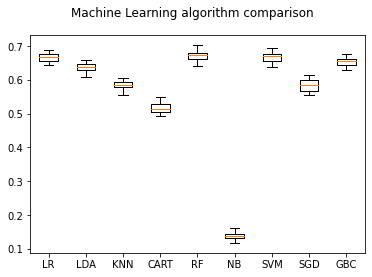

In [71]:
# boxplot algorithm comparison including stochastic gradient descent and gradient boosting classifiers. 
fig = plt.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [72]:
#test_df = pd.read_csv(base_url+'testset_students.csv')
test_df = pd.read_csv(base_url + 'test_data_simplified_students.csv')
test_df.head()

,ID
0,772800977
1,373497125
2,361268494
3,483957657
4,698405955


In [73]:
#Random Forest

# create the model - Logistic Regression
# this also may take a while on Colab for the same I/O issue, I stoped it after 20 minutes
clf  = RandomForestClassifier(n_estimators=num_trees, random_state=seed)

# fit the training data to the model
clf.fit(prepared_X_train, prepared_y_train[0])

# loop through the test images

preds = []
global_test_features = []

for row in test_df.iterrows():
    # get the image file name
    file = base_url + "images/"  + str(row[1]['ID']) + ".jpg"

    # read the image and resize it to a fixed-size
    image = cv2.imread(file)
    image = cv2.resize(image, fixed_size)

    ####################################
    # Global Feature extraction
    ####################################
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick   = fd_haralick(image)
    fv_histogram  = fd_histogram(image, bins = 8)

    ###################################
    # Concatenate global features
    ###################################
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
    
    # scale features in the range (0-1) using the trainset scaler
    rescaled_feature = scaler.transform(global_feature.reshape(1,-1))
    
    prediction = clf.predict(rescaled_feature)[0]


    # update the list of predictions and feature vectors
    preds.append(prediction)
    global_test_features.append(rescaled_feature)

Model seems to be always saying positive, investigate further!

In [74]:
import collections
collections.Counter(preds)

Counter({2: 75, 3: 5, 4: 2024})

It is mostly saying 4 (which is the +ve class). Since we don't have the lavels for the test set, let's see the confusion matrix on the train data.

Random Forest

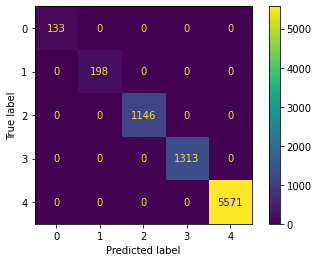

In [75]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
clf  =  RandomForestClassifier(n_estimators=num_trees, random_state=seed)

# fit the training data to the model
clf.fit(prepared_X_train, prepared_y_train[0])

true_labels = prepared_y_train[0]
pred_labels = clf.predict(prepared_X_train)
cm = confusion_matrix(true_labels, pred_labels, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

Concise formatting of results to df and csv for submission

In [76]:
pred_df = pd.DataFrame(preds)
df_final = pd.merge(test_df, pred_df, left_index=True, right_index=True)
df_new = df_final.rename(columns={0:'Label'})
le.inverse_transform(target)
label_list = list(df_new['Label'])
df_new_labels_inverse_transform = list(le.inverse_transform(label_list))
df_new['Label'] =  df_new_labels_inverse_transform
df_new.head() # Check that it looks right before pushing to csv. 

,ID,Label
0,772800977,Positive
1,373497125,Positive
2,361268494,Positive
3,483957657,Positive
4,698405955,Positive


**Random Forest**
Convert to csv

In [77]:
df_new.to_csv(index = False)

'ID,Label\n772800977,Positive\n373497125,Positive\n361268494,Positive\n483957657,Positive\n698405955,Positive\n982040161,Positive\n137762127,Positive\n628000850,Positive\n733350868,Positive\n482269455,Positive\n898609289,Negative\n266971908,Positive\n638459074,Positive\n214868962,Positive\n501416241,Positive\n898312212,Positive\n214683818,Positive\n149629153,Positive\n197858876,Positive\n557558282,Positive\n309826536,Positive\n217484606,Positive\n601081545,Positive\n890580731,Positive\n991044732,Positive\n559469465,Positive\n371306957,Positive\n503845940,Positive\n739772254,Positive\n518890091,Positive\n309336726,Positive\n884550077,Positive\n515756470,Positive\n137210213,Positive\n114280832,Positive\n535761291,Positive\n266901017,Positive\n269554828,Positive\n160388270,Positive\n847383658,Positive\n657855503,Positive\n248255697,Positive\n689875367,Negative\n949570515,Positive\n771708512,Positive\n482430921,Positive\n787529623,Positive\n631511792,Positive\n989467661,Positive\n688865306

SVM

In [78]:
# create the model - Logistic Regression
# this also may take a while on Colab for the same I/O issue, I stoped it after 20 minutes
clf  = SVC(random_state=seed)

# fit the training data to the model
clf.fit(prepared_X_train, prepared_y_train[0])

# loop through the test images

preds = []
global_test_features = []

for row in test_df.iterrows():
    # get the image file name
    file = base_url + "images/"  + str(row[1]['ID']) + ".jpg"

    # read the image and resize it to a fixed-size
    image = cv2.imread(file)
    image = cv2.resize(image, fixed_size)

    ####################################
    # Global Feature extraction
    ####################################
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick   = fd_haralick(image)
    fv_histogram  = fd_histogram(image, bins = 8)

    ###################################
    # Concatenate global features
    ###################################
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
    
    # scale features in the range (0-1) using the trainset scaler
    rescaled_feature = scaler.transform(global_feature.reshape(1,-1))
    
    prediction = clf.predict(rescaled_feature)[0]


    # update the list of predictions and feature vectors
    preds.append(prediction)
    global_test_features.append(rescaled_feature)

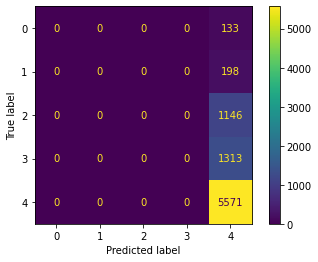

In [79]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
clf  =  SVC(random_state=seed)

# fit the training data to the model
clf.fit(prepared_X_train, prepared_y_train[0])

true_labels = prepared_y_train[0]
pred_labels = clf.predict(prepared_X_train)
cm = confusion_matrix(true_labels, pred_labels, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

In [80]:
pred_df = pd.DataFrame(preds)
df_final = pd.merge(test_df, pred_df, left_index=True, right_index=True)
df_new = df_final.rename(columns={0:'Label'})
le.inverse_transform(target)
label_list = list(df_new['Label'])
df_new_labels_inverse_transform = list(le.inverse_transform(label_list))
df_new['Label'] =  df_new_labels_inverse_transform
df_new.head() # Check that it looks right before pushing to csv. 

,ID,Label
0,772800977,Positive
1,373497125,Positive
2,361268494,Positive
3,483957657,Positive
4,698405955,Positive


**SVM CSV**

In [81]:
df_new.to_csv(index = False)


'ID,Label\n772800977,Positive\n373497125,Positive\n361268494,Positive\n483957657,Positive\n698405955,Positive\n982040161,Positive\n137762127,Positive\n628000850,Positive\n733350868,Positive\n482269455,Positive\n898609289,Positive\n266971908,Positive\n638459074,Positive\n214868962,Positive\n501416241,Positive\n898312212,Positive\n214683818,Positive\n149629153,Positive\n197858876,Positive\n557558282,Positive\n309826536,Positive\n217484606,Positive\n601081545,Positive\n890580731,Positive\n991044732,Positive\n559469465,Positive\n371306957,Positive\n503845940,Positive\n739772254,Positive\n518890091,Positive\n309336726,Positive\n884550077,Positive\n515756470,Positive\n137210213,Positive\n114280832,Positive\n535761291,Positive\n266901017,Positive\n269554828,Positive\n160388270,Positive\n847383658,Positive\n657855503,Positive\n248255697,Positive\n689875367,Positive\n949570515,Positive\n771708512,Positive\n482430921,Positive\n787529623,Positive\n631511792,Positive\n989467661,Positive\n688865306

Logistic Regression


In [82]:
# create the model - Logistic Regression
# this also may take a while on Colab for the same I/O issue, I stoped it after 20 minutes
clf  = LogisticRegression(random_state=seed)

# fit the training data to the model
clf.fit(prepared_X_train, prepared_y_train[0])

# loop through the test images

preds = []
global_test_features = []

for row in test_df.iterrows():
    # get the image file name
    file = base_url + "images/"  + str(row[1]['ID']) + ".jpg"

    # read the image and resize it to a fixed-size
    image = cv2.imread(file)
    image = cv2.resize(image, fixed_size)

    ####################################
    # Global Feature extraction
    ####################################
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick   = fd_haralick(image)
    fv_histogram  = fd_histogram(image, bins = 8)

    ###################################
    # Concatenate global features
    ###################################
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
    
    # scale features in the range (0-1) using the trainset scaler
    rescaled_feature = scaler.transform(global_feature.reshape(1,-1))
    
    prediction = clf.predict(rescaled_feature)[0]


    # update the list of predictions and feature vectors
    preds.append(prediction)
    global_test_features.append(rescaled_feature)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


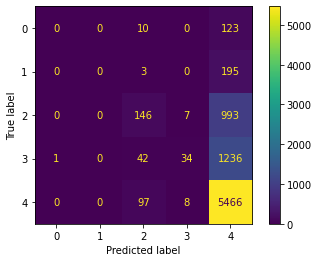

In [83]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
clf  =  LogisticRegression(random_state=seed)

# fit the training data to the model
clf.fit(prepared_X_train, prepared_y_train[0])

true_labels = prepared_y_train[0]
pred_labels = clf.predict(prepared_X_train)
cm = confusion_matrix(true_labels, pred_labels, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

In [84]:
pred_df = pd.DataFrame(preds)
df_final = pd.merge(test_df, pred_df, left_index=True, right_index=True)
df_new = df_final.rename(columns={0:'Label'})
le.inverse_transform(target)
label_list = list(df_new['Label'])
df_new_labels_inverse_transform = list(le.inverse_transform(label_list))
df_new['Label'] =  df_new_labels_inverse_transform
df_new.head() # Check that it looks right before pushing to csv. 

,ID,Label
0,772800977,Positive
1,373497125,Positive
2,361268494,Positive
3,483957657,Negative
4,698405955,Positive


Logistic regression csv

In [85]:
df_new.to_csv(index = False)

'ID,Label\n772800977,Positive\n373497125,Positive\n361268494,Positive\n483957657,Negative\n698405955,Positive\n982040161,Positive\n137762127,Positive\n628000850,Positive\n733350868,Positive\n482269455,Positive\n898609289,Negative\n266971908,Positive\n638459074,Positive\n214868962,Positive\n501416241,Positive\n898312212,Positive\n214683818,Positive\n149629153,Positive\n197858876,Positive\n557558282,Positive\n309826536,Positive\n217484606,Positive\n601081545,Positive\n890580731,Positive\n991044732,Positive\n559469465,Positive\n371306957,Positive\n503845940,Positive\n739772254,Positive\n518890091,Positive\n309336726,Positive\n884550077,Positive\n515756470,Positive\n137210213,Positive\n114280832,Positive\n535761291,Positive\n266901017,Positive\n269554828,Positive\n160388270,Positive\n847383658,Positive\n657855503,Positive\n248255697,Positive\n689875367,Positive\n949570515,Positive\n771708512,Negative\n482430921,Positive\n787529623,Positive\n631511792,Negative\n989467661,Positive\n688865306